Vocab size: 14222, #Tags: 12, #Sentences: 57340


100%|██████████| 5734/5734 [00:01<00:00, 3216.37it/s]


[Supervised] Dev accuracy: 0.670


100%|██████████| 5734/5734 [00:01<00:00, 3208.16it/s]


[Unsupervised] Dev accuracy: 0.131
Supervised tags: ['PRT', 'PRON', 'VERB', 'NOUN']
Unsupervised tags: ['CONJ', 'NOUN', 'CONJ', 'NUM']
Overall Precision: 0.8644166530096671
Overall Recall: 0.6698206344629954
Overall F1: 0.7130529773983149
              precision    recall  f1-score   support

           .      0.298     1.000     0.460     14594
         ADJ      0.854     0.565     0.680      8194
         ADP      0.964     0.592     0.734     14111
         ADV      0.893     0.608     0.724      5617
        CONJ      0.994     0.604     0.751      3743
         DET      0.993     0.665     0.796     13626
        NOUN      0.935     0.599     0.730     27030
         NUM      0.971     0.549     0.702      1420
        PRON      0.975     0.736     0.839      4962
         PRT      0.885     0.632     0.738      2867
        VERB      0.972     0.655     0.783     18117
           X      0.416     0.320     0.362       178

    accuracy                          0.670    114459
   

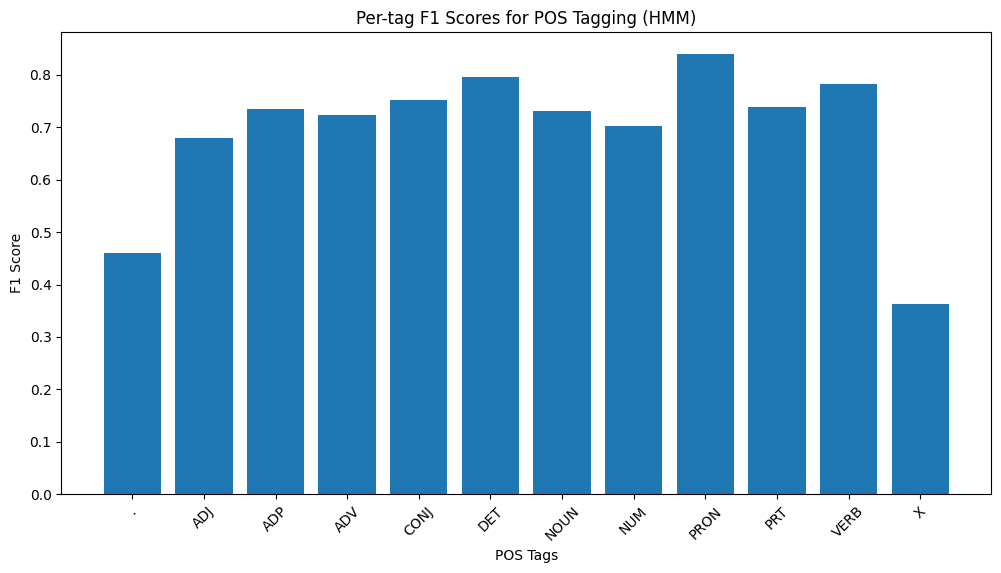

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from typing import Tuple, List, Dict, Iterable
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt


# =========================
# HMM with two training modes
# =========================
class HiddenMarkovModel:
    def __init__(self, N: int, T: int, init: str = "uniform", seed: int = 42):
        """
        N: number of hidden states
        T: number of observation symbols (vocab size)
        init: "uniform" or "dirichlet" (random)
        """
        self.N = int(N)
        self.T = int(T)
        rng = np.random.default_rng(seed)

        if init == "dirichlet":
            self.pi = rng.dirichlet(np.ones(self.N)).astype(np.float32)
            self.A  = rng.dirichlet(np.ones(self.N), size=self.N).astype(np.float32)
            self.B  = rng.dirichlet(np.ones(self.T), size=self.N).astype(np.float32)
        else:
            self.pi = np.ones(self.N, dtype=np.float32) / self.N
            self.A  = np.ones((self.N, self.N), dtype=np.float32) / self.N
            self.B  = np.ones((self.N, self.T), dtype=np.float32) / self.T

    # --------- Forward / Backward / Viterbi ----------
    def forward(self, O: np.ndarray) -> Tuple[np.ndarray, float]:
        T_len = len(O)
        fwd = np.zeros((T_len, self.N), dtype=np.float32)
        fwd[0] = self.pi * self.B[:, O[0]]
        for t in range(1, T_len):
            # fwd[t][s] = sum_k fwd[t-1][k] * A[k,s] * B[s, O[t]]
            fwd[t] = (fwd[t-1] @ self.A) * self.B[:, O[t]]
        return fwd, float(np.sum(fwd[-1]))

    def backward(self, O: np.ndarray) -> Tuple[np.ndarray, float]:
        T_len = len(O)
        back = np.zeros((T_len, self.N), dtype=np.float32)
        back[-1] = 1.0
        for t in range(T_len - 2, -1, -1):
            # back[t][s] = sum_j A[s,j] * B[j,O[t+1]] * back[t+1][j]
            back[t] = self.A @ (self.B[:, O[t+1]] * back[t+1])
        prob = float(np.sum(self.pi * self.B[:, O[0]] * back[0]))
        return back, prob

    def viterbi(self, O: np.ndarray) -> Tuple[np.ndarray, float]:
        T_len = len(O)
        v = np.zeros((T_len, self.N), dtype=np.float32)
        bptr = np.zeros((T_len, self.N), dtype=int)

        v[0] = self.pi * self.B[:, O[0]]
        bptr[0] = -1
        for t in range(1, T_len):
            # For each state s, choose best previous k
            seq_probs = v[t-1][:, None] * self.A  # shape: (N, N) -> k->s
            bptr[t] = np.argmax(seq_probs, axis=0)
            v[t]    = seq_probs[bptr[t], np.arange(self.N)] * self.B[:, O[t]]

        max_prob = float(np.max(v[-1]))
        last = int(np.argmax(v[-1]))

        path = np.zeros(T_len, dtype=int)
        for t in range(T_len - 1, -1, -1):
            path[t] = last
            last = bptr[t, last]
        return path, max_prob

    # --------- Supervised training ----------
    def fit_supervised(self, X: List[np.ndarray], Y: List[np.ndarray]) -> None:
        """
        X: list of observation sequences (word indices)
        Y: list of gold state sequences (tag indices), same lengths as X
        Estimates MLE for pi, A, B.
        """
        pi = np.zeros(self.N, dtype=np.float32)
        A  = np.zeros((self.N, self.N), dtype=np.float32)
        B  = np.zeros((self.N, self.T), dtype=np.float32)

        for x_seq, y_seq in zip(X, Y):
            if len(y_seq) == 0: 
                continue
            pi[y_seq[0]] += 1.0
            for t in range(len(y_seq) - 1):
                A[y_seq[t], y_seq[t+1]] += 1.0
            for t in range(len(y_seq)):
                B[y_seq[t], x_seq[t]] += 1.0

        # Normalize with smoothing to avoid zero rows
        self.pi = self._safe_row_norm(pi)
        self.A  = self._safe_row_norm(A)
        self.B  = self._safe_row_norm(B)

    # --------- Unsupervised training (Baum–Welch, memory-efficient) ----------
    def fit_unsupervised(self, X: List[np.ndarray], n_iters: int = 10) -> None:
        for _ in tqdm(range(n_iters)):
            # Accumulators across all sentences
            pi_acc  = np.zeros(self.N, dtype=np.float32)
            A_num   = np.zeros((self.N, self.N), dtype=np.float32)
            A_den   = np.zeros(self.N, dtype=np.float32)
            B_num   = np.zeros((self.N, self.T), dtype=np.float32)
            B_den   = np.zeros(self.N, dtype=np.float32)

            for O in X:
                if len(O) == 0:
                    continue
                alpha, _ = self.forward(O)
                beta,  _ = self.backward(O)
                # gamma[t, s] ∝ alpha[t, s] * beta[t, s]
                gamma = alpha * beta
                gamma /= np.sum(gamma, axis=1, keepdims=True) + 1e-12

                # Accumulate pi, B
                pi_acc += gamma[0]
                B_den  += np.sum(gamma, axis=0)
                # For each timestep, add gamma[t] into column of the observed symbol
                for t, ot in enumerate(O):
                    B_num[:, ot] += gamma[t]

                # A via on-the-fly xi accumulation, no full epsilon tensor
                for t in range(len(O) - 1):
                    # xi[i, j] ∝ alpha[t,i] * A[i,j] * B[j, O[t+1]] * beta[t+1, j]
                    xi = (alpha[t][:, None] * self.A) * (self.B[:, O[t+1]] * beta[t+1])[None, :]
                    xi_sum = np.sum(xi)
                    if xi_sum > 0:
                        xi /= xi_sum
                    A_num += xi
                    A_den += np.sum(xi, axis=1)

            # Re-estimate
            self.pi = self._safe_row_norm(pi_acc)
            self.A  = A_num / (A_den[:, None] + 1e-12)
            self.B  = B_num / (B_den[:, None] + 1e-12)

            # Row-normalize just in case of numerical drift
            self.A  = self._safe_row_norm(self.A)
            self.B  = self._safe_row_norm(self.B)

    # --------- Utility ----------
    def predict(self, O: np.ndarray) -> Tuple[np.ndarray, float]:
        return self.viterbi(O)

    @staticmethod
    def _safe_row_norm(M: np.ndarray) -> np.ndarray:
        M = M.astype(np.float32, copy=False)
        if M.ndim == 1:
            s = float(np.sum(M))
            if s == 0:
                return np.ones_like(M, dtype=np.float32) / len(M)
            return (M / s).astype(np.float32)
        s = np.sum(M, axis=1, keepdims=True)
        M = M / (s + 1e-12)
        # replace NaNs if any row was all zeros
        nan_rows = ~np.isfinite(M).all(axis=1)
        M[nan_rows] = 1.0 / M.shape[1]
        return M.astype(np.float32)

# =========================
# Brown corpus preparation (Universal tagset)
# =========================
def prepare_brown_data(min_freq: int = 3):
    """
    Returns:
      X: List[np.ndarray] of word indices
      Y: List[np.ndarray] of tag indices (gold, for supervised)
      word2idx, idx2word, tag2idx, idx2tag
    """
    import nltk
    from nltk.corpus import brown
    from collections import Counter

    nltk.download("brown", quiet=True)
    nltk.download("universal_tagset", quiet=True)

    tagged_sents = brown.tagged_sents(tagset="universal")

    # vocab with <UNK>
    words = [w.lower() for sent in tagged_sents for (w, _) in sent]
    freqs = Counter(words)
    vocab = ["<UNK>"] + [w for w, c in freqs.items() if c >= min_freq]
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for w, i in word2idx.items()}

    # tags (fixed small set)
    tags = sorted({t for sent in tagged_sents for (_, t) in sent})
    tag2idx = {t: i for i, t in enumerate(tags)}
    idx2tag = {i: t for t, i in tag2idx.items()}

    X, Y = [], []
    for sent in tagged_sents:
        ws, ts = zip(*sent)
        x = np.array([word2idx.get(w.lower(), 0) for w in ws], dtype=np.int32)
        y = np.array([tag2idx[t] for t in ts], dtype=np.int32)
        X.append(x)
        Y.append(y)

    print(f"Vocab size: {len(vocab)}, #Tags: {len(tags)}, #Sentences: {len(X)}")
    return X, Y, word2idx, idx2word, tag2idx, idx2tag

# =========================
# Simple evaluation (tag accuracy)
# =========================
def evaluate(hmm: HiddenMarkovModel,
             X: List[np.ndarray],
             Y: List[np.ndarray]) -> float:
    """
    Decodes with Viterbi and computes micro accuracy vs. gold tags.
    """
    correct = 0
    total = 0
    for x, y in tqdm(zip(X, Y), total=len(X)):
        path, _ = hmm.predict(x)
        L = min(len(path), len(y))
        correct += int(np.sum(path[:L] == y[:L]))
        total += L
    return correct / max(total, 1)

# =========================
# Example usage
# =========================
if __name__ == "__main__":
   # Prep data
    X, Y, word2idx, idx2word, tag2idx, idx2tag = prepare_brown_data(min_freq=5)
    
    # Split into train/dev
    from sklearn.model_selection import train_test_split
    X_train, X_dev, Y_train, Y_dev = train_test_split(
        X, Y, test_size=0.1, random_state=42, shuffle=True
    )
    
    N = len(tag2idx)    # number of hidden states
    T = len(word2idx)   # number of observation symbols
    
    # -------- Supervised HMM --------
    hmm_sup = HiddenMarkovModel(N, T, init="uniform")
    hmm_sup.fit_supervised(X_train, Y_train)
    sup_acc = evaluate(hmm_sup, X_dev, Y_dev)
    print(f"[Supervised] Dev accuracy: {sup_acc:.3f}")
    
    # -------- Unsupervised HMM --------
    hmm_unsup = HiddenMarkovModel(N, T, init="dirichlet", seed=123)
    hmm_unsup.fit_unsupervised(X_train, n_iters=30)  # EM iterations
    unsup_acc = evaluate(hmm_unsup, X_dev, Y_dev)
    print(f"[Unsupervised] Dev accuracy: {unsup_acc:.3f}")
    
    # -------- Test a custom sentence --------
    sent = ["Hi", "I", "am", "Rishi"]
    x = np.array([word2idx.get(w.lower(), 0) for w in sent], dtype=np.int32)
    
    path_sup, prob_sup = hmm_sup.predict(x)
    print("Supervised tags:", [idx2tag[i] for i in path_sup])
    
    path_unsup, prob_unsup = hmm_unsup.predict(x)
    print("Unsupervised tags:", [idx2tag[i] for i in path_unsup])
    
    # -------- Metrics on Dev Set (Supervised Model) --------
    from sklearn.metrics import precision_recall_fscore_support, classification_report
    import matplotlib.pyplot as plt
    
    # Predict tags for dev sentences using Viterbi
    Y_pred = []
    for x in X_dev:
        path, _ = hmm_sup.predict(np.array(x, dtype=np.int32))
        Y_pred.append([idx2tag[i] for i in path])
    
    # Flatten to token level
    y_true = [idx2tag[tag] for sent in Y_dev for tag in sent]
    y_pred = [tag for sent in Y_pred for tag in sent]
    
    # ✅ Overall precision, recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    print("Overall Precision:", precision)
    print("Overall Recall:", recall)
    print("Overall F1:", f1)
    
    # ✅ Per-tag precision, recall, F1
    report = classification_report(y_true, y_pred, digits=3, output_dict=True)
    print(classification_report(y_true, y_pred, digits=3))
    
    # Extract per-tag F1 for plotting
    tags = list(report.keys())[:-3]  # drop summary rows
    f1_scores = [report[tag]['f1-score'] for tag in tags]
    
    # ✅ Plot per-tag F1 scores
    plt.figure(figsize=(12,6))
    plt.bar(tags, f1_scores)
    plt.xticks(rotation=45)
    plt.xlabel("POS Tags")
    plt.ylabel("F1 Score")
    plt.title("Per-tag F1 Scores for POS Tagging (HMM)")
    plt.show()



===== Supervised HMM =====
Overall Precision: 0.864
Overall Recall: 0.67
Overall F1: 0.713
              precision    recall  f1-score   support

           .      0.298     1.000     0.460     14594
         ADJ      0.854     0.565     0.680      8194
         ADP      0.964     0.592     0.734     14111
         ADV      0.893     0.608     0.724      5617
        CONJ      0.994     0.604     0.751      3743
         DET      0.993     0.665     0.796     13626
        NOUN      0.935     0.599     0.730     27030
         NUM      0.971     0.549     0.702      1420
        PRON      0.975     0.736     0.839      4962
         PRT      0.885     0.632     0.738      2867
        VERB      0.972     0.655     0.783     18117
           X      0.416     0.320     0.362       178

    accuracy                          0.670    114459
   macro avg      0.846     0.627     0.692    114459
weighted avg      0.864     0.670     0.713    114459


===== Unsupervised HMM =====
Overall Pre

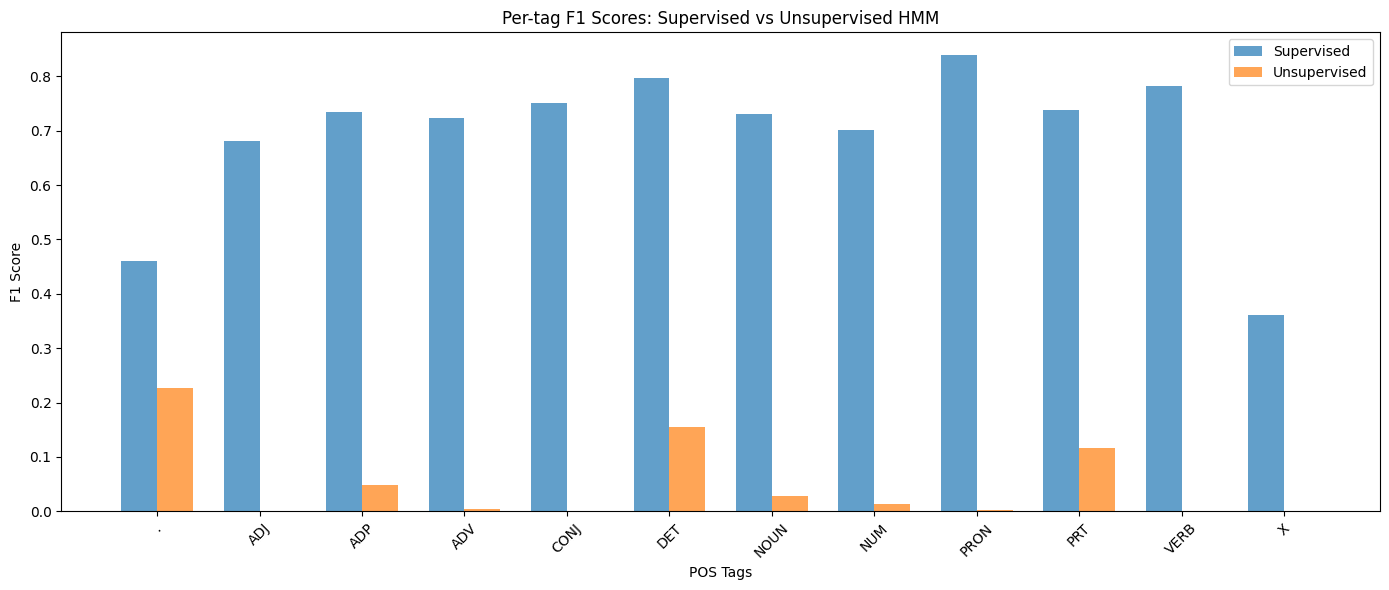

In [2]:
# -------- Metrics & Plots for Supervised and Unsupervised --------
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

def evaluate_and_plot(model, X_dev, Y_dev, idx2tag, title="Model"):
    # Predict tags for dev sentences
    Y_pred = []
    for x in X_dev:
        path, _ = model.predict(np.array(x, dtype=np.int32))
        Y_pred.append([idx2tag[i] for i in path])

    # Flatten to token level
    y_true = [idx2tag[tag] for sent in Y_dev for tag in sent]
    y_pred = [tag for sent in Y_pred for tag in sent]

    # ✅ Overall precision, recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    print(f"\n===== {title} =====")
    print("Overall Precision:", round(precision, 3))
    print("Overall Recall:", round(recall, 3))
    print("Overall F1:", round(f1, 3))

    # ✅ Per-tag precision, recall, F1
    report = classification_report(y_true, y_pred, digits=3, output_dict=True)
    print(classification_report(y_true, y_pred, digits=3))

    # Extract per-tag F1 for plotting
    tags = list(report.keys())[:-3]  # drop summary rows
    f1_scores = [report[tag]['f1-score'] for tag in tags]

    return tags, f1_scores


# ---- Evaluate both models ----
tags_sup, f1_sup = evaluate_and_plot(hmm_sup, X_dev, Y_dev, idx2tag, title="Supervised HMM")
tags_unsup, f1_unsup = evaluate_and_plot(hmm_unsup, X_dev, Y_dev, idx2tag, title="Unsupervised HMM")

# ---- Plot both side by side ----
plt.figure(figsize=(14,6))

x = range(len(tags_sup))
bar_width = 0.35

plt.bar(x, f1_sup, width=bar_width, label="Supervised", alpha=0.7)
plt.bar([i + bar_width for i in x], f1_unsup, width=bar_width, label="Unsupervised", alpha=0.7)

plt.xticks([i + bar_width/2 for i in x], tags_sup, rotation=45)
plt.xlabel("POS Tags")
plt.ylabel("F1 Score")
plt.title("Per-tag F1 Scores: Supervised vs Unsupervised HMM")
plt.legend()
plt.tight_layout()
plt.show()